In [1]:
import json
import pandas as pd
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sivakumarreddysurasani/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sivakumarreddysurasani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def load_filtered_data(filepath, start_year, end_year):
    filtered_data = []
    with open(filepath, 'r') as f:
        for line in f:
            paper = json.loads(line)

            update_date = paper.get("update_date")
            if update_date:
                paper_date = datetime.strptime(update_date, "%Y-%m-%d")

                if start_year <= paper_date.year <= end_year:
                    filtered_data.append({
                        "title": paper.get("title"),
                        "abstract": paper.get("abstract"),
                        "update_date": paper.get("update_date"),
                        "authors_parsed": paper.get("authors_parsed"),
                        "categories": paper.get("categories"),
                        "submitter": paper.get("submitter"),
                        "journal-ref": paper.get("journal-ref")
                    })

    return filtered_data


file_path ="dataset.json"

start_year = 2023
end_year = 2024

filtered_data = load_filtered_data(file_path, start_year, end_year)

df = pd.DataFrame(filtered_data)


df['categories'].unique()



array(['astro-ph', 'quant-ph math-ph math.MP', 'math.AT math.DG', ...,
       'q-bio.QM cond-mat.stat-mech math.PR', 'solv-int nlin.SI',
       'solv-int nlin.PS nlin.SI patt-sol'], dtype=object)

In [21]:
import pandas as pd
from collections import Counter

all_categories = [cat for categories in df['categories'] for cat in categories.split()]

category_counts = Counter(all_categories)

category_counts_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Frequency'])

category_counts_df = category_counts_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

top_categories = category_counts_df[100:105]
print("Top categories by frequency:")
print(top_categories)


Top categories by frequency:
           Category  Frequency
100           cs.ET       1965
101         math.OA       1924
102  physics.med-ph       1889
103           cs.PL       1872
104         econ.EM       1846


In [22]:
diverse_categories = [ 'cs.ET', 'math.OA', 'physics.med-ph',  'cs.PL', 'econ.EM']
diverse_dataset = df[df['categories'].apply(lambda x: any(cat in x for cat in diverse_categories))].copy()
diverse_dataset['categories'] = diverse_dataset['categories'].apply(
    lambda x: [cat for cat in x.split() if cat in diverse_categories]
)
mlb_diverse = MultiLabelBinarizer()
y_diverse_binarized = mlb_diverse.fit_transform(diverse_dataset['categories'])
y_diverse_binarized

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [23]:
import spacy
!python3 -m spacy download en_core_web_sm
from rake_nltk import Rake

nlp = spacy.load('en_core_web_sm')

def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

r = Rake()

def extract_keyphrases(text):
    r.extract_keywords_from_text(text)
    ranked_phrases = r.get_ranked_phrases()

    return [phrase for phrase in ranked_phrases if len(phrase.split()) > 1]

/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 3.6 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


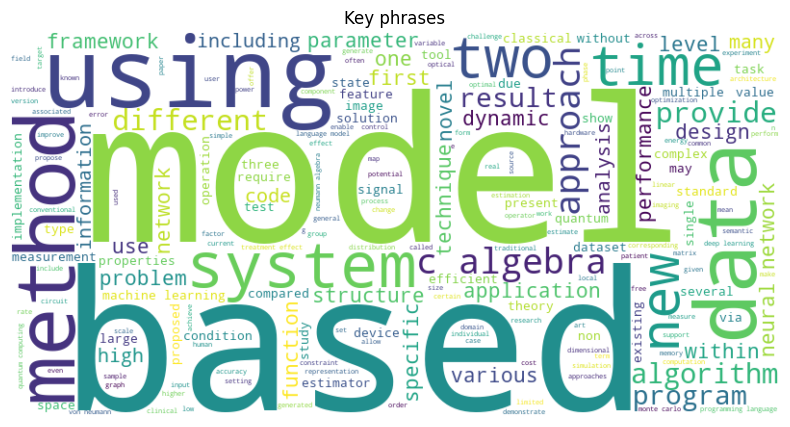

In [24]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

diverse_dataset['processed_abstract'] = diverse_dataset['abstract'].apply(preprocess_text)
diverse_dataset['ner'] = diverse_dataset['abstract'].apply(extract_ner)
diverse_dataset['keyphrases'] = diverse_dataset['abstract'].apply(extract_keyphrases)
def plot_wordcloud(keyphrases, title):
    all_keyphrases = ' '.join([' '.join(phrase) for phrase in keyphrases])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_keyphrases)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(diverse_dataset['keyphrases'], "Key phrases")


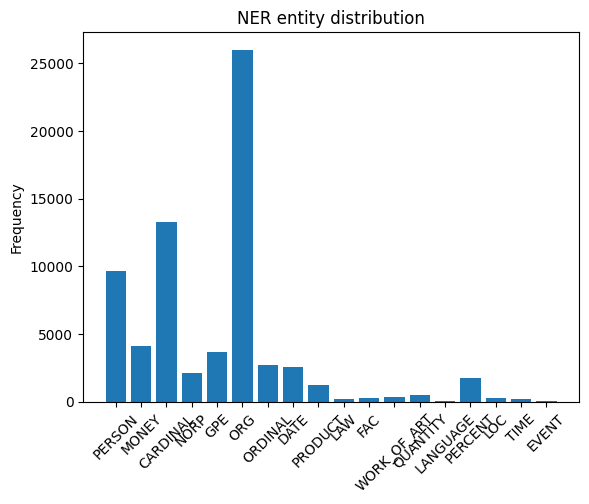

In [25]:
def plot_ner_distribution(df, title):
    all_entities = [entity[1] for entities in df['ner'] for entity in entities]
    entity_counter = Counter(all_entities)
    plt.bar(entity_counter.keys(), entity_counter.values())
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()
plot_ner_distribution(diverse_dataset, "NER entity distribution")


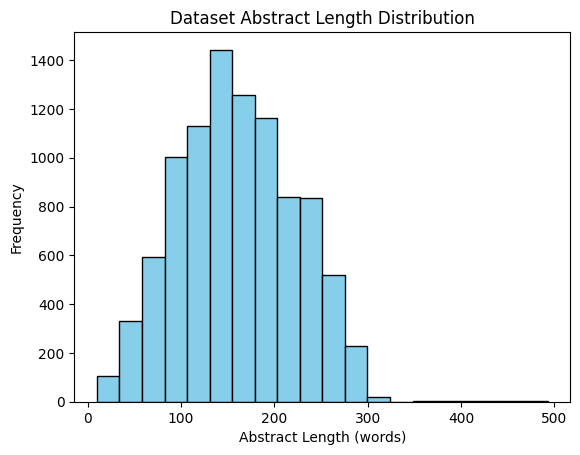

In [26]:
def plot_length_distribution(df, title):
    df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))
    df['abstract_length'].plot(kind='hist', bins=20, title=title, color='skyblue', edgecolor='black')
    plt.xlabel('Abstract Length (words)')
    plt.ylabel('Frequency')
    plt.show()
plot_length_distribution(diverse_dataset, "Dataset Abstract Length Distribution")

In [27]:
vectorizer = TfidfVectorizer(max_features=1000)
diverse_tfidf = vectorizer.fit_transform(diverse_dataset['processed_abstract'])

X_diverse_train, X_diverse_test, y_diverse_train, y_diverse_test = train_test_split(
    diverse_tfidf, y_diverse_binarized, test_size=0.2, random_state=42
)


def evaluate_model(true_labels, predictions):
    print(classification_report(true_labels, predictions, zero_division=0))
    print("Accuracy:", accuracy_score(true_labels, predictions))


from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Function to train and evaluate models
from sklearn.metrics import log_loss

# Function to train models and record accuracy and loss
def train_models(X_train, y_train, X_test, y_test, dataset_name):
    print(f"--- {dataset_name} Dataset ---")

    results = {
        'model': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': []
    }

    # Naive Bayes with OneVsRest
    nb_model = OneVsRestClassifier(MultinomialNB())
    nb_model.fit(X_train, y_train)

    # Predictions and scores
    nb_train_predictions = nb_model.predict(X_train)
    nb_val_predictions = nb_model.predict(X_test)

    train_accuracy = accuracy_score(y_train, nb_train_predictions)
    val_accuracy = accuracy_score(y_test, nb_val_predictions)

    train_loss = log_loss(y_train, nb_model.predict_proba(X_train))
    val_loss = log_loss(y_test, nb_model.predict_proba(X_test))

    # Store results
    results['model'].append("Naive Bayes")
    results['train_accuracy'].append(train_accuracy)
    results['val_accuracy'].append(val_accuracy)
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)

    print("Naive Bayes Results")
    evaluate_model(y_test, nb_val_predictions)

    # SVM with OneVsRest
    svm_model = OneVsRestClassifier(SVC(probability=True))  # Enable probability for log_loss
    svm_model.fit(X_train, y_train)

    svm_train_predictions = svm_model.predict(X_train)
    svm_val_predictions = svm_model.predict(X_test)

    train_accuracy = accuracy_score(y_train, svm_train_predictions)
    val_accuracy = accuracy_score(y_test, svm_val_predictions)

    train_loss = log_loss(y_train, svm_model.predict_proba(X_train))
    val_loss = log_loss(y_test, svm_model.predict_proba(X_test))

    # Store results
    results['model'].append("SVM")
    results['train_accuracy'].append(train_accuracy)
    results['val_accuracy'].append(val_accuracy)
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)

    print("SVM Results")
    evaluate_model(y_test, svm_val_predictions)

    # Random Forest with OneVsRest
    rf_model = OneVsRestClassifier(RandomForestClassifier())
    rf_model.fit(X_train, y_train)

    rf_train_predictions = rf_model.predict(X_train)
    rf_val_predictions = rf_model.predict(X_test)

    train_accuracy = accuracy_score(y_train, rf_train_predictions)
    val_accuracy = accuracy_score(y_test, rf_val_predictions)

    train_loss = log_loss(y_train, rf_model.predict_proba(X_train))
    val_loss = log_loss(y_test, rf_model.predict_proba(X_test))

    # Store results
    results['model'].append("Random Forest")
    results['train_accuracy'].append(train_accuracy)
    results['val_accuracy'].append(val_accuracy)
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)

    print("Random Forest Results")
    evaluate_model(y_test, rf_val_predictions)

    return results




In [30]:
import matplotlib.pyplot as plt

# Function to plot training vs. validation accuracy and loss
def plot_training_validation_results(results, dataset_name):
    models = results['model']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot accuracy
    axes[0].bar(models, results['train_accuracy'], width=0.4, label='Train Accuracy', align='center', color='skyblue')
    axes[0].bar(models, results['val_accuracy'], width=0.4, label='Validation Accuracy', align='edge', color='orange')
    axes[0].set_title(f'{dataset_name} Dataset: Training vs Validation Accuracy')
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plot loss
    axes[1].bar(models, results['train_loss'], width=0.4, label='Train Loss', align='center', color='skyblue')
    axes[1].bar(models, results['val_loss'], width=0.4, label='Validation Loss', align='edge', color='orange')
    axes[1].set_title(f'{dataset_name} Dataset: Training vs Validation Loss')
    axes[1].set_xlabel('Models')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


--- Diverse Dataset ---
Naive Bayes Results
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       361
           1       0.93      0.87      0.90       401
           2       0.98      0.89      0.93       356
           3       0.97      0.97      0.97       399
           4       0.96      0.90      0.93       385

   micro avg       0.95      0.88      0.91      1902
   macro avg       0.94      0.88      0.91      1902
weighted avg       0.95      0.88      0.91      1902
 samples avg       0.87      0.88      0.87      1902

Accuracy: 0.8545071164997364


/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


SVM Results
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       361
           1       0.98      0.89      0.93       401
           2       0.99      0.92      0.96       356
           3       0.99      0.98      0.98       399
           4       0.97      0.91      0.94       385

   micro avg       0.97      0.90      0.93      1902
   macro avg       0.97      0.90      0.93      1902
weighted avg       0.97      0.90      0.93      1902
 samples avg       0.90      0.90      0.90      1902

Accuracy: 0.8924617817606747


/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/sivakumarreddysurasani/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Random Forest Results
              precision    recall  f1-score   support

           0       0.95      0.73      0.82       361
           1       0.96      0.89      0.92       401
           2       0.94      0.87      0.90       356
           3       0.97      0.96      0.97       399
           4       0.96      0.89      0.92       385

   micro avg       0.96      0.87      0.91      1902
   macro avg       0.96      0.86      0.91      1902
weighted avg       0.96      0.87      0.91      1902
 samples avg       0.86      0.87      0.86      1902

Accuracy: 0.849235635213495


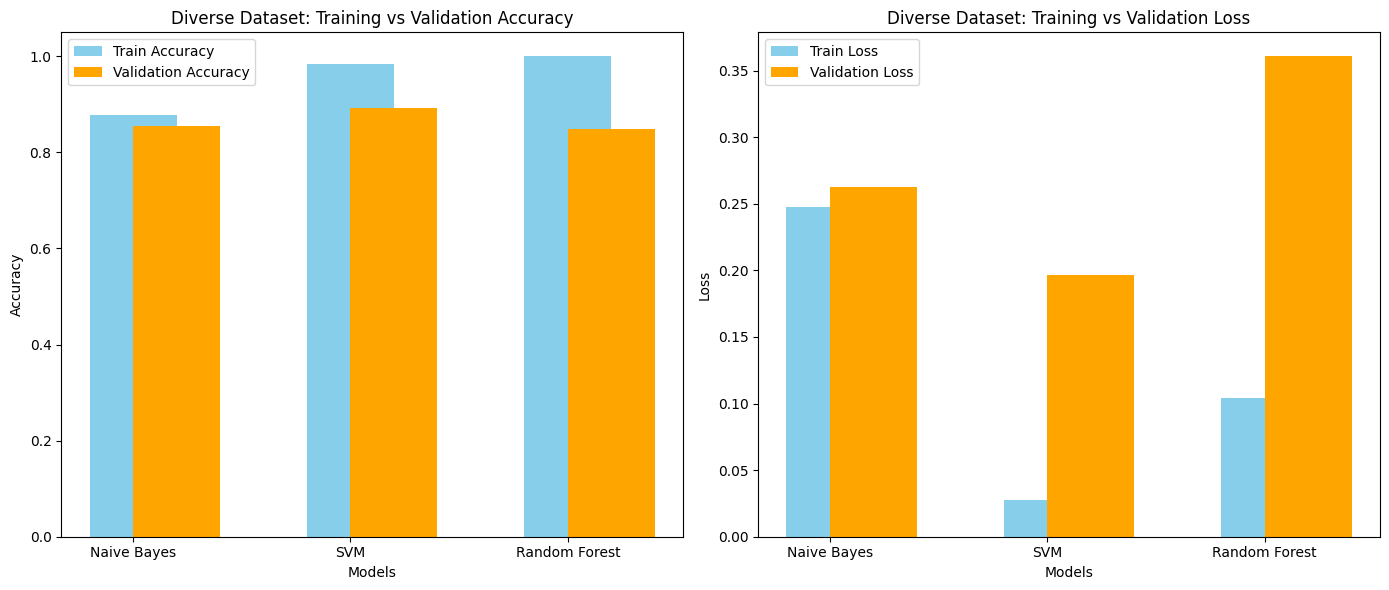

In [31]:
# Train and evaluate on diverse dataset
diverse_results = train_models(X_diverse_train, y_diverse_train, X_diverse_test, y_diverse_test, "Diverse")

# Plot training vs validation accuracy and loss for diverse dataset
plot_training_validation_results(diverse_results, "Diverse")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


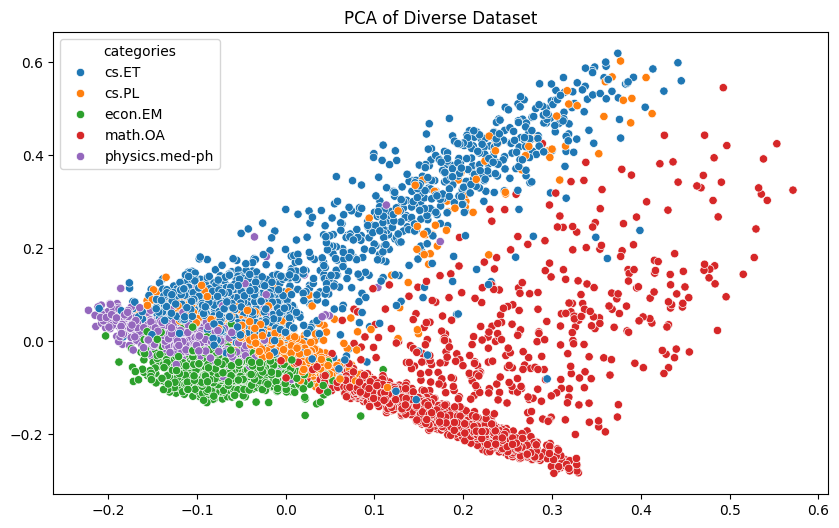

Topics for Diverse Dataset
Topic 1:
quantum computing networks hardware systems circuits learning energy data devices
Topic 2:
treatment model estimator effects models data estimation estimators inference regression
Topic 3:
imaging images image model reconstruction data using method dose clinical
Topic 4:
algebra group groups algebras calgebras quantum space operator operators prove
Topic 5:
code language programming programs program languages type semantics llms types


In [32]:
!pip3 install seaborn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Function to perform PCA and plot
def apply_pca_and_plot(X_tfidf, dataset, dataset_name):
    # Ensure 'categories' is a pandas Series and convert to categorical type
    if isinstance(dataset['categories'].iloc[0], list):
        dataset['categories'] = dataset['categories'].apply(lambda x: x[0])  # Take the first category if it's a list
    dataset['categories'] = pd.Categorical(dataset['categories'])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_tfidf.toarray())

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=dataset['categories'])
    plt.title(f"PCA of {dataset_name} Dataset")
    plt.show()
apply_pca_and_plot(diverse_tfidf, diverse_dataset, "Diverse")


from sklearn.decomposition import LatentDirichletAllocation


# Function to apply LDA and display topics
def apply_lda(X_tfidf, vectorizer, dataset_name):
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X_tfidf)

    print(f"Topics for {dataset_name} Dataset")
    display_topics(lda, vectorizer.get_feature_names_out(), 10)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Apply LDA for diverse dataset
apply_lda(diverse_tfidf, vectorizer, "Diverse")

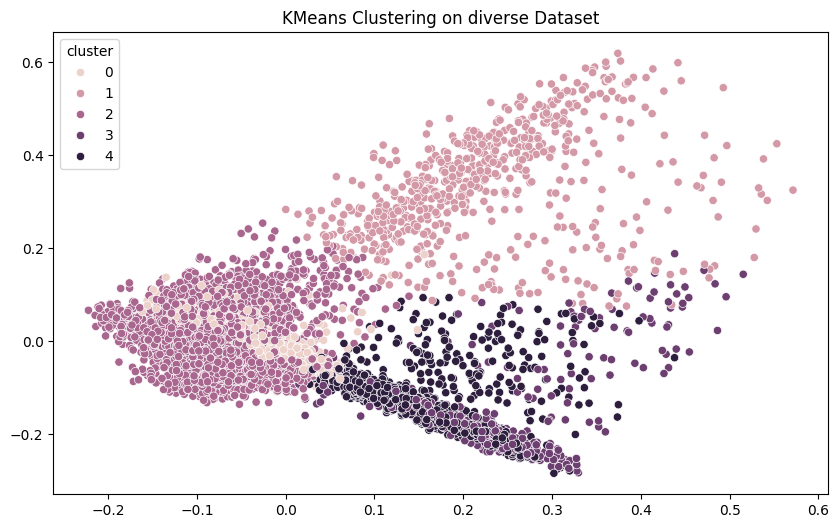

In [34]:
from sklearn.cluster import KMeans

# Function to perform KMeans clustering and plot
def apply_kmeans_and_plot(X_tfidf, dataset, dataset_name):
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_tfidf)

    # Add cluster labels to the dataset
    dataset['cluster'] = kmeans_labels

    # Plot clusters
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_tfidf.toarray())
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=dataset['cluster'])
    plt.title(f"KMeans Clustering on {dataset_name} Dataset")
    plt.show()
apply_kmeans_and_plot(diverse_tfidf, diverse_dataset, "diverse")